In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from pyts.image import MarkovTransitionField
import dask.dataframe as dd  
import pandas as pd


from scipy import signal as sign
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
ddf = dd.read_parquet("dataset/train.parquet", engine="pyarrow")
df_metadata = pd.read_csv('dataset/metadata_train.csv')

In [3]:
np.random.seed(42)
# Index 1

index_1 = np.where(df_metadata[['target']].T.to_numpy()[0]==1)[0]
len_index_1 = len(index_1)
index_train_1, index_test_1 = index_1[:len_index_1//2], index_1[len_index_1//2:]

# Index 0

index_0 = np.where(df_metadata[['target']].T.to_numpy()[0]==0)[0]
index_train_0, index_test_0 = index_0[:len_index_1//2], index_0[len_index_1//2:len_index_1]


index_train = np.concatenate([index_train_0, index_train_1])
np.random.shuffle(index_train)

index_test = np.concatenate([index_test_0, index_test_1])
np.random.shuffle(index_test)

print(index_train)

[ 706 2834    9  187   81 2170 4214 3613  120  140   13 4126   78 2682
 3521  143    2  158 1824  134 4070  294  436  295 1026  432  258 3570
 4213 4086 4165   58 1803 2323   33   76 1019   71   12   82  104  107
  286  135 2642  941   75  236 1337   80 4166   93 2516 4143  223  215
  127  183 3239 1135 1032  242  878 2195   73 2118  151   87   66 1449
   92  253  180   36   79   85    0   14  255   25  261 2354  233 4160
  161 2418   21  185 1028   18 3206   42 3614   49   96  170  214 1577
 2420  434 3310 2277  572 2985  156  225   72 1450 3243  176 2322  239
  216  195 1033  940  227  157 2344  179 1826 2193  209 3204  287 3032
 3572   89 3275  198 2169   22 1134   59 1737 1085 2952  256   28 2986
   45 3372  269  175  435  129 1074   34  116  237  235 1136   60 1885
   27   20  201   69  710 4159   97 1050 1331   26  257  272 4053    8
  119   48 4036 2099   19 3768 1805    6 3373 2965   63  113 1027  280
   32 1456  188   29   10  184 3519  111   40  160 3912  121  117  271
  178 

(129,) (3571,) (129, 3571)


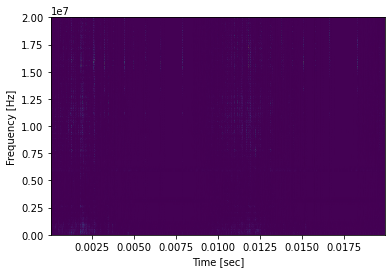

In [4]:
signal = ddf["706"].compute()

fs = 8e5/20e-3

f, t, Sxx = sign.spectrogram(signal, fs)

print(f.shape, t.shape, Sxx.shape)

plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


array([[ -5.42949   ,  -5.2923675 , -12.463088  , ...,  -9.115722  ,
         -4.909926  ,  -3.7110088 ],
       [ -3.806716  ,  -3.5292633 ,  -7.6927004 , ...,  -4.331261  ,
         -0.75375444,  -2.1205924 ],
       [ -0.9480632 ,  -0.4234077 ,   0.7107365 , ...,   4.0969663 ,
          6.56769   ,   0.6810595 ],
       ...,
       [  3.8470044 ,   8.16576   ,   5.5855064 , ...,  18.178253  ,
         29.562279  ,  33.359764  ],
       [  3.7443087 ,   7.43866   ,   5.2508087 , ...,  18.181168  ,
         29.884516  ,  32.47588   ],
       [  3.6860113 ,   7.0259066 ,   5.060811  , ...,  18.182823  ,
         30.06744   ,  31.974123  ]], dtype=float32)

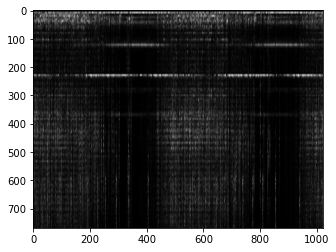

In [5]:
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,255))
Sxx = scaler.fit_transform(Sxx)

img = Image.fromarray(Sxx).resize((1024, 768))


plt.imshow(img)
img = np.array(img)
img

In [6]:
from tqdm import tqdm
images = []
fs = 8e5/20e-3 # Sampling frequency
img_size = 256, 256 # Size for all images
input_size = 



for col in tqdm(index_train):
    # Get signal
    signal = ddf[str(col)].compute()

    # Get spectrogram from signal
    f, t, Sxx = sign.spectrogram(signal, fs)
    # Transform spectrogram to image range (0, 255)
    scaler = MinMaxScaler(feature_range=(0,255))
    Sxx = scaler.fit_transform(Sxx)
    # Resize image
    img = np.array(Image.fromarray(Sxx).resize(img_size))
    images.append(img)
    
images = np.array(images).reshape((524, 256, 256, 1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 524/524 [00:37<00:00, 13.88it/s]


In [7]:
labels = df_metadata[["target"]].loc[index_train]
print(labels)
labels.shape

      target
706        1
2834       1
9          0
187        0
81         0
...      ...
74         0
109        0
270        1
2640       1
105        0

[524 rows x 1 columns]


(524, 1)

<IPython.core.display.Javascript object>


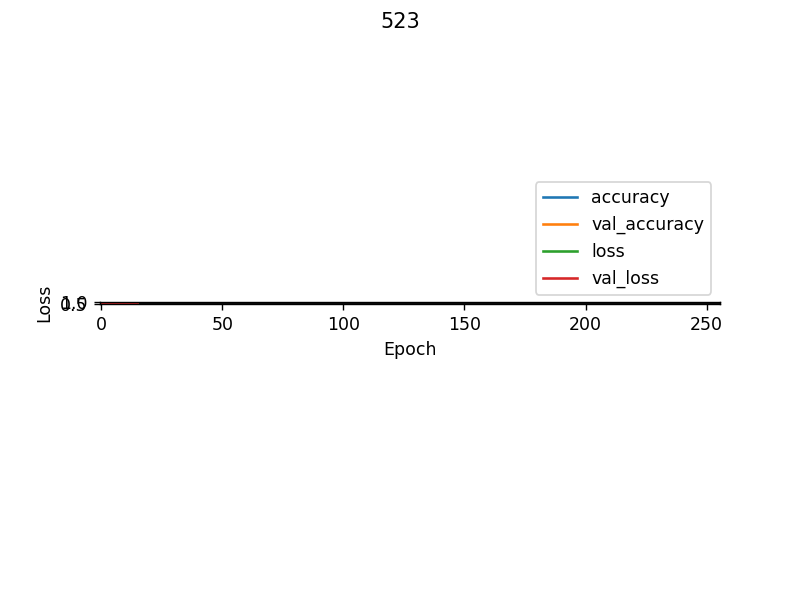

In [8]:
%matplotlib notebook
n_signal = 0
fig = plt.figure() # make figure
im = plt.imshow(images[0], cmap='gray')

# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(images[j])
    fig.suptitle(str(j))
    # return the artists set
    return [im]
# kick off the animation
ani = animation.FuncAnimation(fig, updatefig, 
                              interval=10, blit=True)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)

In [10]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


2022-09-27 10:13:05.666237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-27 10:13:05.875461: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-27 10:13:05.953826: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-27 10:13:06.627959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [11]:
# Creación de modelo
model = models.Sequential()
# Capas encargadas de obtener información de la imagen
model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(256,256,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Capas para la clasificación en base a la información obtenida en 
# capas anteriores
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 256)     2560      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 flatten (Flatten)           (None, 230400)            0

2022-09-27 10:13:08.674900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 10:13:08.766263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 10:13:08.766390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 10:13:08.767455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 7)

model.compile(loss = 'bce', optimizer = 'adam', metrics=['accuracy', tf.keras.metrics.Recall()])
history_cnn = model.fit(X_train, y_train, epochs=100, 
                        validation_data=(X_val, y_val),
                        batch_size=10,
                        callbacks=[early_stopping])

Epoch 1/100


2022-09-27 10:13:10.733223: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8300
2022-09-27 10:13:12.048752: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-27 10:13:12.048790: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-27 10:13:12.278327: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


37/37 [==============================] - 12s 194ms/step - loss: 4.7414 - accuracy: 0.6421 - recall: 0.7650 - val_loss: 0.6411 - val_accuracy: 0.6203 - val_recall: 0.4810
Epoch 2/100


2022-09-27 10:13:21.345565: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-27 10:13:21.345598: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


37/37 [==============================] - 5s 143ms/step - loss: 0.5390 - accuracy: 0.7541 - recall: 0.8306 - val_loss: 0.4924 - val_accuracy: 0.7405 - val_recall: 0.7089
Epoch 3/100
37/37 [==============================] - 5s 142ms/step - loss: 0.4320 - accuracy: 0.8033 - recall: 0.8251 - val_loss: 0.4062 - val_accuracy: 0.7785 - val_recall: 0.8987
Epoch 4/100
37/37 [==============================] - 5s 142ms/step - loss: 0.3149 - accuracy: 0.8525 - recall: 0.8962 - val_loss: 0.3612 - val_accuracy: 0.8228 - val_recall: 0.8481
Epoch 5/100
37/37 [==============================] - 5s 143ms/step - loss: 0.2090 - accuracy: 0.9126 - recall: 0.9071 - val_loss: 0.3919 - val_accuracy: 0.8354 - val_recall: 0.8734
Epoch 6/100
37/37 [==============================] - 5s 142ms/step - loss: 0.1685 - accuracy: 0.9180 - recall: 0.9180 - val_loss: 0.3074 - val_accuracy: 0.8481 - val_recall: 0.9494
Epoch 7/100
37/37 [==============================] - 5s 142ms/step - loss: 0.1648 - accuracy: 0.9481 - reca

In [13]:
plt.plot(history_cnn.history['accuracy'], label='accuracy')
plt.plot(history_cnn.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()



In [14]:
plt.plot(history_cnn.history['loss'], label='loss')
plt.plot(history_cnn.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [15]:
test_loss, test_acc, test_recall = model.evaluate(X_val,  y_val, verbose=2, batch_size=10)

16/16 - 0s - loss: 0.3524 - accuracy: 0.9051 - recall: 0.9114 - 354ms/epoch - 22ms/step


In [16]:
predictions = (model.predict(X_val, batch_size=10)>0.8).reshape(1,-1)[0].astype(int)
# predictions = model.predict(X_val, batch_size=10)
# class_predictions = np.argmax(predictions,axis=1)
real_values = y_val.T.to_numpy()[0]

print(predictions)
print(real_values)

16/16 [==============================] - 0s 21ms/step
[0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0
 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1
 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 0
 1 0 1 0 1 0 0 1 1 0]
[0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0
 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0
 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1
 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 0
 1 0 1 0 1 0 0 1 1 0]


In [17]:
# Test
from tqdm import tqdm
images_test = []
fs = 8e5/20e-3 # Sampling frequency
img_size = 256, 256 # Size for all images
# index_test = index_test[0:499]


for col in tqdm(index_test):
    # Get signal
    signal = ddf[str(col)].compute()

    # Get spectrogram from signal
    f, t, Sxx = sign.spectrogram(signal, fs)
    # Transform spectrogram to image range (0, 255)
    scaler = MinMaxScaler(feature_range=(0,255))
    Sxx = scaler.fit_transform(Sxx)
    # Resize image
    img = np.array(Image.fromarray(Sxx).resize(img_size))
    images_test.append(img)

images_test = np.array(images_test).reshape((526, 256, 256, 1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 526/526 [00:39<00:00, 13.28it/s]


In [18]:
labels_test = df_metadata[["target"]].loc[index_test]

In [19]:
print(images_test.shape)
print(labels_test.shape)

(526, 256, 256, 1)
(526, 1)


In [20]:
X_test = images_test
y_test = labels_test

In [21]:
test_loss, test_acc, test_recall = model.evaluate(X_test,  y_test, verbose=2, batch_size=10)

53/53 - 1s - loss: 3.3803 - accuracy: 0.7376 - recall: 0.8365 - 1s/epoch - 21ms/step


In [22]:
predictions = (model.predict(X_test, batch_size=10)>0.8).reshape(1,-1)[0].astype(int)
# predictions = model.predict(X_val, batch_size=10)
real_values = y_test.T.to_numpy()[0]

print(predictions)
print(real_values)

53/53 [==============================] - 1s 21ms/step
[1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 1
 1 1 0 0 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 0
 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1
 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1
 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1
 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1
 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0
 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0
 1 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1
 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1
 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0
 0 1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0
 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 1

In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(real_values, predictions)

In [35]:
# Transfer Learning
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False # Esto impide que las capas se re entrenen

In [49]:
X_train_rgb = np.repeat(X_train, 3, -1)
X_val_rgb = np.repeat(X_val, 3, -1)
X_test_rgb = np.repeat(X_test, 3, -1)

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 7)

model.compile(loss = 'bce', optimizer = 'adam', metrics=['accuracy', tf.keras.metrics.Recall()])
history_cnn = model.fit(X_train_rgb, y_train, epochs=100, 
                        validation_data=(X_val_rgb, y_val),
                        batch_size=10,
                        callbacks=[early_stopping])

Epoch 1/100
37/37 [==============================] - 4s 60ms/step - loss: 0.5403 - accuracy: 0.7186 - recall_6: 0.6721 - val_loss: 0.5050 - val_accuracy: 0.7278 - val_recall_6: 0.8734
Epoch 2/100
37/37 [==============================] - 1s 37ms/step - loss: 0.4342 - accuracy: 0.8005 - recall_6: 0.8415 - val_loss: 0.4748 - val_accuracy: 0.7532 - val_recall_6: 0.7215
Epoch 3/100
37/37 [==============================] - 1s 37ms/step - loss: 0.3946 - accuracy: 0.8169 - recall_6: 0.8415 - val_loss: 0.4429 - val_accuracy: 0.7595 - val_recall_6: 0.8734
Epoch 4/100
37/37 [==============================] - 1s 37ms/step - loss: 0.3522 - accuracy: 0.8443 - recall_6: 0.8634 - val_loss: 0.4453 - val_accuracy: 0.7595 - val_recall_6: 0.8987
Epoch 5/100
37/37 [==============================] - 1s 38ms/step - loss: 0.3449 - accuracy: 0.8361 - recall_6: 0.8525 - val_loss: 0.4088 - val_accuracy: 0.7848 - val_recall_6: 0.8734
Epoch 6/100
37/37 [==============================] - 1s 37ms/step - loss: 0.3180

37/37 [==============================] - 1s 38ms/step - loss: 0.0956 - accuracy: 0.9836 - recall_6: 0.9945 - val_loss: 0.2718 - val_accuracy: 0.8861 - val_recall_6: 0.8608
Epoch 46/100
37/37 [==============================] - 1s 38ms/step - loss: 0.0944 - accuracy: 0.9863 - recall_6: 0.9945 - val_loss: 0.2612 - val_accuracy: 0.8924 - val_recall_6: 0.9114
Epoch 47/100
37/37 [==============================] - 1s 38ms/step - loss: 0.0935 - accuracy: 0.9863 - recall_6: 0.9945 - val_loss: 0.2598 - val_accuracy: 0.8797 - val_recall_6: 0.9241
Epoch 48/100
37/37 [==============================] - 1s 38ms/step - loss: 0.0916 - accuracy: 0.9891 - recall_6: 0.9945 - val_loss: 0.2638 - val_accuracy: 0.8861 - val_recall_6: 0.9367
Epoch 49/100
37/37 [==============================] - 1s 38ms/step - loss: 0.0902 - accuracy: 0.9891 - recall_6: 0.9945 - val_loss: 0.2624 - val_accuracy: 0.8797 - val_recall_6: 0.8861
Epoch 50/100
37/37 [==============================] - 1s 38ms/step - loss: 0.0903 - accu

In [52]:
test_loss, test_acc, test_recall = model.evaluate(X_val_rgb,  y_val, verbose=2, batch_size=10)

predictions = (model.predict(X_val_rgb, batch_size=10)>0.5).reshape(1,-1)[0].astype(int)
# predictions = model.predict(X_val, batch_size=10)
# class_predictions = np.argmax(predictions,axis=1)
real_values = y_val.T.to_numpy()[0]

print(predictions)
print(real_values)

16/16 - 0s - loss: 0.2451 - accuracy: 0.8924 - recall_6: 0.9367 - 413ms/epoch - 26ms/step
16/16 [==============================] - 0s 24ms/step
[0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1
 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0
 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1
 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0
 1 0 1 0 0 0 0 1 1 0]
[0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0
 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0
 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1
 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 0
 1 0 1 0 1 0 0 1 1 0]


In [53]:
test_loss, test_acc, test_recall = model.evaluate(X_test_rgb,  y_test, verbose=2, batch_size=10)

predictions = (model.predict(X_test_rgb, batch_size=10)>0.5).reshape(1,-1)[0].astype(int)
# predictions = model.predict(X_val, batch_size=10)
real_values = y_test.T.to_numpy()[0]

print(predictions)
print(real_values)

53/53 - 1s - loss: 0.4324 - accuracy: 0.8593 - recall_6: 0.8745 - 1s/epoch - 25ms/step
53/53 [==============================] - 1s 24ms/step
[1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1
 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1
 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1
 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0
 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1
 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0
 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0
 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1
 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1
 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1
 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1

In [54]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(real_values, predictions)

0.7189638735315257